In [1]:
# Import functions and libraries
from __future__ import division
%pylab
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys
from numpy import *
from scipy import *
import scipy.signal as signal
from rtlsdr import RtlSdr
from numpy.fft import *
from scipy import signal

import serial
%matplotlib inline


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
0.705339403349# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Phase')
    plt.tight_layout()
    
def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def play_audio( Q, p, fs , dev, ser="", keydelay=0.200):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data=="EOT"  :
            break
        elif (data=="KEYOFF"  and ser!=""):
            time.sleep(keydelay)
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data=="KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list



In [3]:
def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name

In [4]:
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 HDA Intel HDMI: 0 (hw:0,3)
1 HDA Intel HDMI: 1 (hw:0,7)
2 HDA Intel HDMI: 2 (hw:0,8)
3 HDA Intel PCH: ALC3232 Analog (hw:1,0)
4 hdmi
5 pulse
6 default


In [5]:
dusb_in = 2
dusb_out = 2
din = 0
dout = 1

left:
1. near center (30 deg)
2. more left (45 deg)
3. 60 deg
4. 80
5. 90 deg
repeat left, closer but reverse order
6. 


10. 90 deg
11. 45

1-5 was radial 8
6-9 radial 7
10- radial 5

right:
1) 30 deg
2. 45
prev radial 7
6 and on radial 5
7 45 deg
8. 90 deg

walk:
1. continuous (from left)
2. continuous (from right)
3. pulses (from left)
4. pulses (from right)

center
1 - 8
2 - 7
3 - radial 5
4 - 4
5- 3
6 - 2
7 - 1
8 - 0.5
9- dead center

final_countdown
0 - 0 deg
1 - 30 deg left
2 - 45 deg left
3 - 60 deg left
4 - 75 deg left
5 - 90 deg left
6 - 30 deg right
7 - 45 deg right
8 - 60 deg right
9 - 75 deg right
10 - 90 deg right
11 - 45 deg right back
12 - center back
13 - 45 deg left back
14 - 45 deg left back inner
15 - center back inner
16 - 45 deg right back inner
17 - 30ish deg right
18 - 30ish deg left

In [30]:
# Record from SDRs
%run acquire.py

SDR 0: Acquired 0 samples.
SDR 1: Acquired 0 samples.
SDR 0: Acquired 1024000 samples.
SDR 1: Acquired 1024000 samples.
SDR 0: Closed as fuck.
SDR 1: Closed as fuck.
Printing Queue 0
	- Queue size: 1
1
Done
Printing Queue 1
	- Queue size: 1
1
Done


In [3]:
samples = np.load('final_countdown_11.npy') #can overwrite: 05 07 #06 is Miki's tone #LO_test_10_tone_miki.npy 
#23_radio has a beautiful cross correlation
#04 05 not actually long 

y0 = samples[0]
y1 = samples[1]
print len(samples)

2


###Callibration 

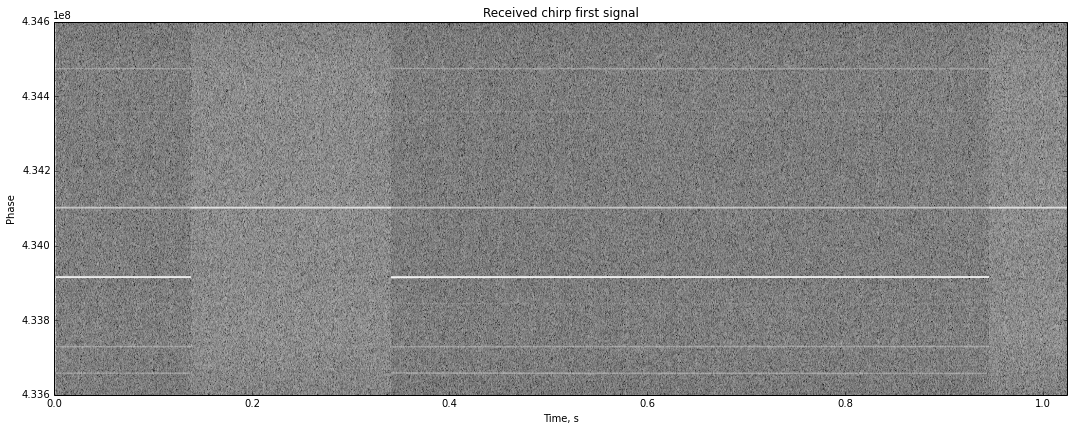

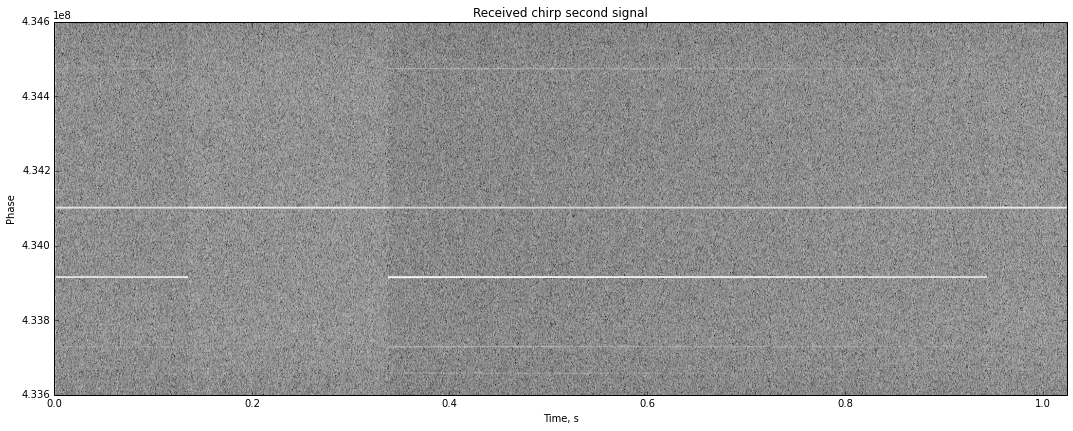

In [5]:
m = 512
fs = 1e6 #1e6 #3.2e6 #240000
fc = 434.1e6 #145.230e6 #145.530e6 #315e6 #144.25e6 #443.61e6

myspectrogram_hann_ovlp(y0, m, fs, fc, dbf = 60)
plt.title('Received chirp first signal')
myspectrogram_hann_ovlp(y1, m, fs, fc, dbf = 60)
plt.title('Received chirp second signal')

In [6]:
def notch_filter(x, f_n, fc, r=0.87):
    b = [1, -2*np.exp(2j*pi*(f_n-fc)/fs), np.exp(2*2j*pi*(f_n-fc)/fs)]
    a = [1, -2*r*np.exp(2j*pi*(f_n-fc)/fs), r*r*np.exp(2*2j*pi*(f_n-fc)/fs)]
    print b
    print a
    return signal.lfilter(b, a, x)

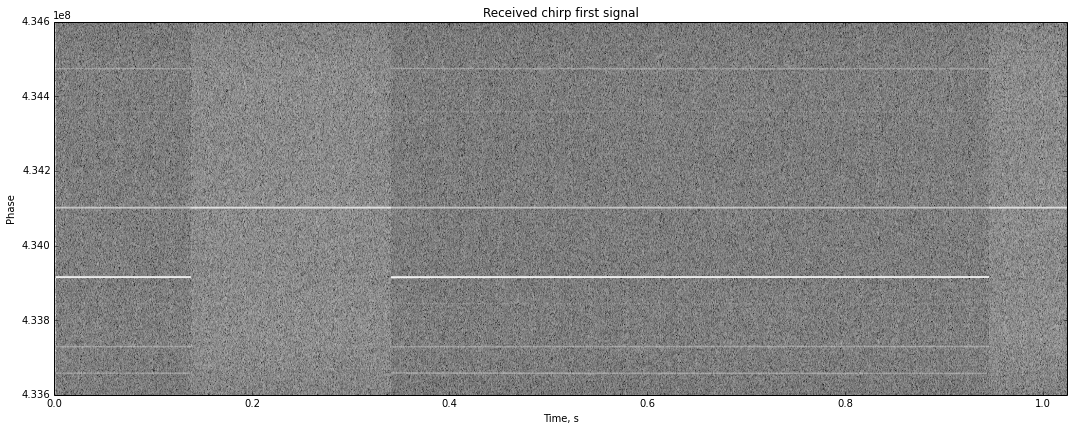

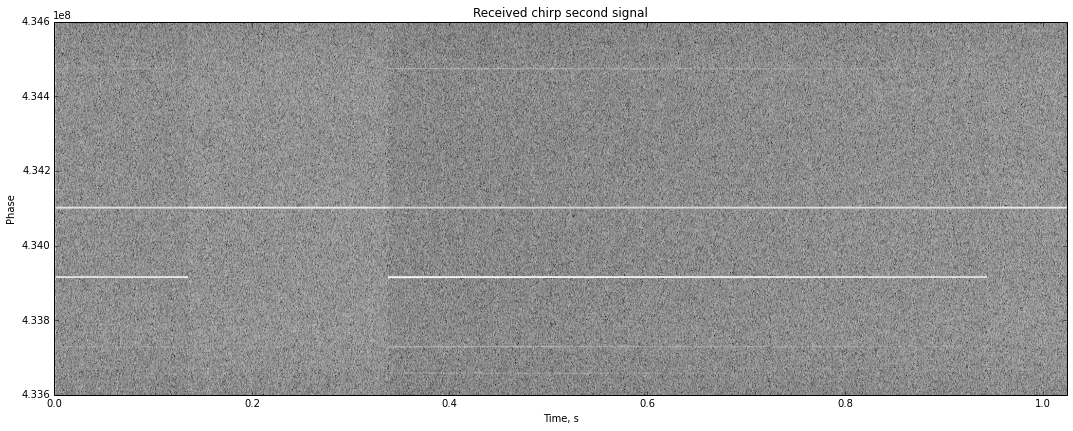

In [7]:
#notched_y0 = notch_filter(y0, 434.1085e6, fc)
#notched_y0 = notch_filter(notched_y0, fc, fc, 0.99)
#notched_y1 = notch_filter(y1, 434.1085e6, fc)
#notched_y1 = notch_filter(notched_y1, fc, fc, 0.99)

myspectrogram_hann_ovlp(y0, m, fs, fc, dbf = 60)
plt.title('Received chirp first signal')
myspectrogram_hann_ovlp(y1, m, fs, fc, dbf = 60)
plt.title('Received chirp second signal')

_ = 0

-184000.0
322110
321973
322124


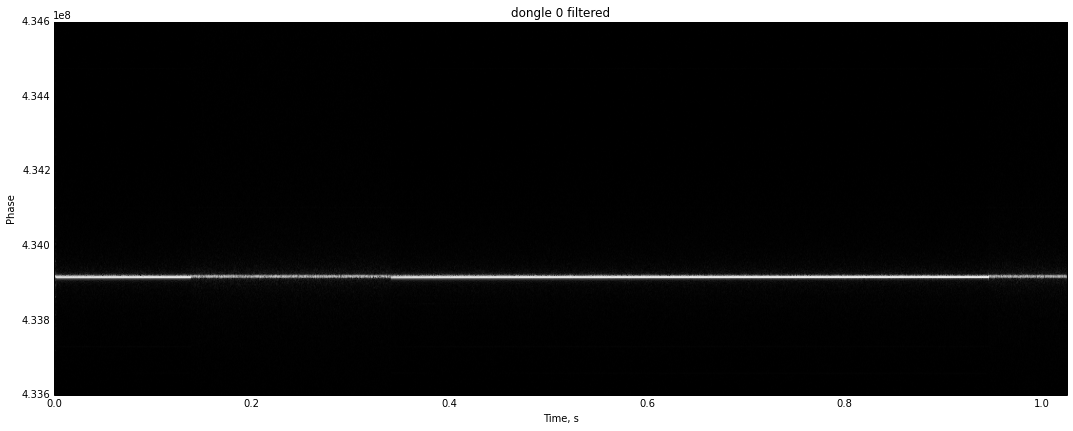

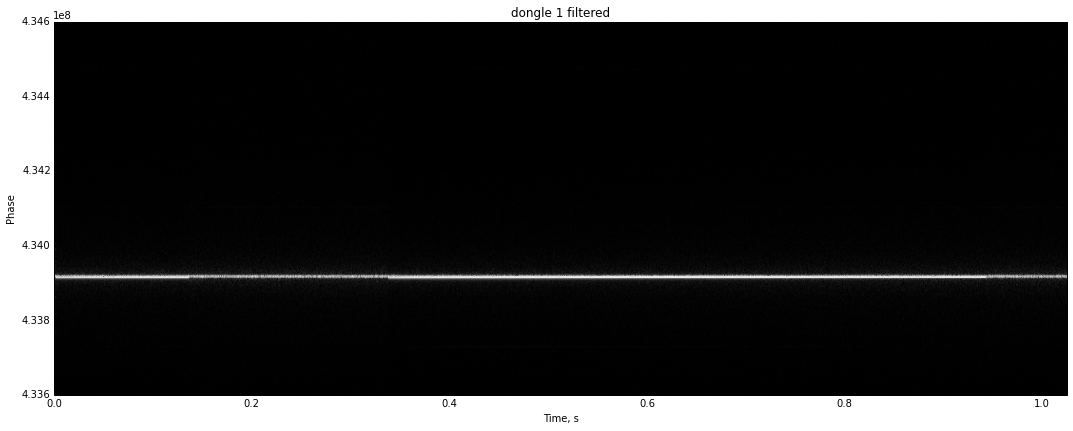

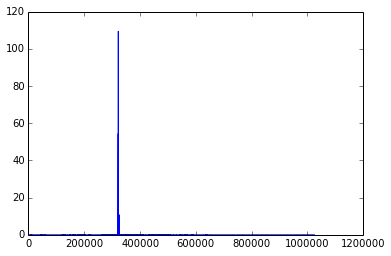

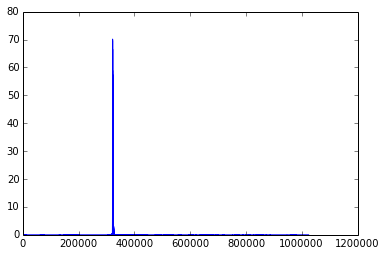

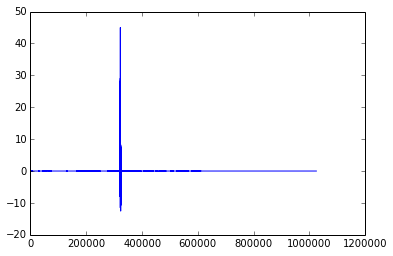

In [8]:
taps = 685
#taps = 700
f0 = 433.916e6#905.043e6
mod_val = f0 - fc #0.04e6 #-0.3e6
print mod_val
h = sp.signal.firwin(taps, 0.5/fs)
t = np.arange(taps) * (1/fs)
mod = exp(1j*2*pi*mod_val*t)
h = h*mod

filt_y0 = signal.fftconvolve(y0, h)
filt_y1 = signal.fftconvolve(y1, h)

trunc_y0 = filt_y0[int(len(h)/2):-(int(len(h)/2))]
trunc_y1 = filt_y1[int(len(h)/2):-(int(len(h)/2))]

assert trunc_y0.size == y0.size
assert trunc_y1.size == y1.size

myspectrogram_hann_ovlp(filt_y0, m, fs, fc,dbf = 63)
title('dongle 0 filtered')
myspectrogram_hann_ovlp(filt_y1, m, fs, fc,dbf = 63)
title('dongle 1 filtered')

freq0 = np.fft.fftshift(np.fft.fft(filt_y0)) 
freq1 = np.fft.fftshift(np.fft.fft(filt_y1)) 
figure()
plt.plot(abs(freq0))
figure()
plt.plot(abs(freq1))

print abs(freq0).tolist().index(max(abs(freq0)))
print abs(freq1).tolist().index(max(abs(freq1)))
print (abs(freq0)-abs(freq1)).tolist().index(max(abs(freq0)-abs(freq1)))

figure()
plt.plot((abs(freq0)-abs(freq1))) #[225000:275000]


2277
2359


/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


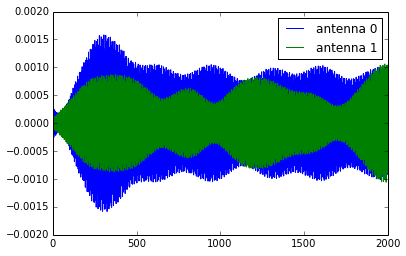

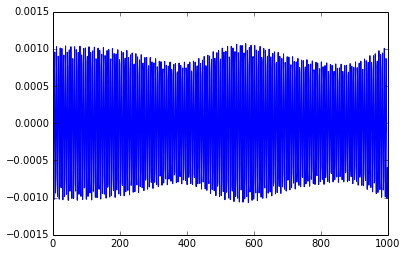

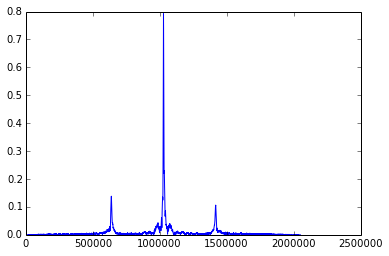

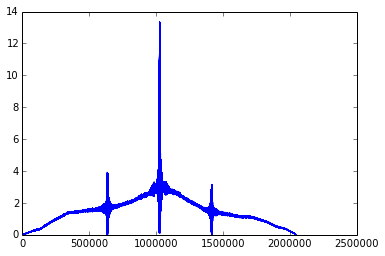

In [9]:
# Calculating USB delay

figure()
plt.plot(filt_y0[2000:4000], label='antenna 0')
plt.plot(filt_y1[2000:4000], label='antenna 1')
plt.legend()

figure()
plt.plot(filt_y0[4000:5000], label='antenna 0')

# figure()
# plt.plot(filt_y0, label='antenna 0')
# plt.plot(filt_y1, label='antenna 1')
# plt.legend()


filt_xcorr_abs = abs(signal.fftconvolve(filt_y0, np.conjugate(filt_y1)[::-1]))
filt_xcorr = signal.fftconvolve(filt_y0, np.conjugate(filt_y1)[::-1])
filt_trun_xcorr_abs = abs(signal.fftconvolve(trunc_y0, (np.conjugate(trunc_y1)[::-1])))
filt_trun_xcorr = signal.fftconvolve(trunc_y0, (np.conjugate(trunc_y1)[::-1]))

figure()
plt.plot(filt_xcorr_abs)
# plt.plot(filt_xcorr)

# figure()
# plt.plot(filt_trun_xcorr_abs)
# plt.plot(filt_trun_xcorr)

orig_xcorr = signal.fftconvolve(y0, np.conjugate(y1)[::-1])
orig_xcorr_abs = abs(signal.fftconvolve(y0, np.conjugate(y1)[::-1]))

figure()
#plt.plot(orig_xcorr)
plt.plot(orig_xcorr_abs)

# print np.argmax(filt_xcorr)-len(y0) + 1
print np.argmax(orig_xcorr_abs)-len(y0) + 1
print np.argmax(filt_xcorr_abs)-len(filt_y0) + 1
# print np.argmax(filt_trun_xcorr_abs)-len(y0) + 1
# print np.argmax(filt_trun_xcorr)-len(y0) + 1
# print np.argmax(orig_xcorr)-len(y0) + 1

delay = np.argmax(orig_xcorr_abs)-len(y0) + 1
# if delay < 0:
#     delay = -delay

trunc_delay = np.argmax(filt_trun_xcorr_abs)-len(trunc_y0) + 1
# if filt_delay < 0:
#     filt_delay = - filt_delay

In [10]:
offsetz = np.array([-1.68056807633, 0.222685923314, -1.56973780438, 2.53638823754, \
                    -2.24505497425, 1.09901875117, 1.36451542563, 0.705339403349, -1.67691494176, 0.195477875708])
print offsetz.mean()
print offsetz.std()

offsetz_pulse = np.array([-1.47010333537, -2.05845840304, 1.39610764898, -0.993814861621, -0.104885018001, \
                          -2.0791659508, 0.328200320148, 1.51878325395, -2.05158064754, -0.879481734035])

print offsetz_pulse.mean()
print offsetz_pulse.std()

phase_offset = offsetz_pulse.mean()

-0.104885018001
1.52049356694
-0.639439872733
1.30296688624


In [11]:
def find_tone(sig, f0, fc, fs, threshold=0.5, burst_len=512):
    t = np.r_[:burst_len]/fs
    tone_burst = np.exp(2j*pi*(f0-fc)*t)

    match = np.abs(signal.fftconvolve(sig, np.conj(tone_burst[::-1]))[int(tone_burst.size/2) - 1: -int(tone_burst.size/2)])
    match /= np.max(match)
    
    assert match.size == sig.size

    matched = match > threshold
    plt.plot(matched)
    plt.ylim(-0.1,1.1)
    
    return matched

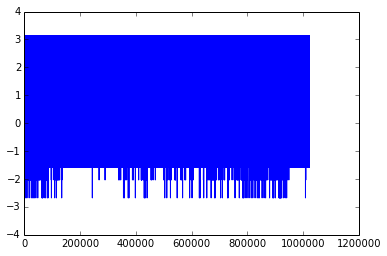

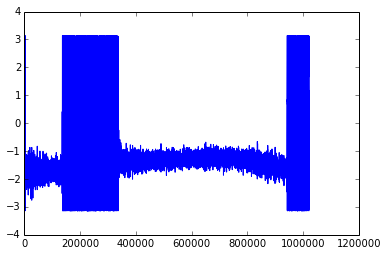

In [12]:
phase_diff_orig = np.angle(y0[delay:] * np.conjugate(y1[:-delay]))
# phase_diff_orig = np.angle(y0[:delay] * np.conjugate(y1[-delay:])) #negative delay

figure()
plt.plot(phase_diff_orig)

#phase_diff_filt = np.angle(filt_y0[filt_delay:] * np.conjugate(filt_y1[:-filt_delay]))
# phase_diff_filt = np.angle(filt_y0[:filt_delay] * np.conjugate(filt_y1[-filt_delay:])) # negative delay

phase_diff = np.angle(trunc_y0[trunc_delay:] * np.conjugate(trunc_y1[:-trunc_delay]))

figure()
plt.plot(phase_diff)

# phase_offset = np.mean(phase_diff_orig[:100000])
# phase_offset = np.mean(phase_diff_orig[200000:400000])
# print phase_offset

#phase_offset = np.mean(phase_diff_filt[:800000])
#print phase_offset

1021723
1021641
-0.639439872733


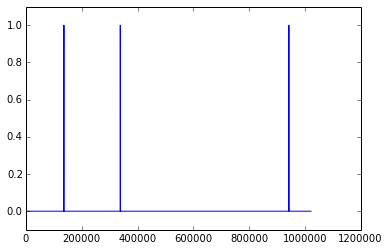

In [13]:
matched = find_tone(trunc_y0[delay:], f0, fc, fs)
print matched.size
print phase_diff.size
#phase_offset = np.mean(phase_diff[matched])
print phase_offset # :/?

In [14]:
def sweep_angle(y0, y1, d, fc, offset, step_size=1/80):
    thetas = np.arange(0,1+step_size,step_size) * 2 * pi
#     phase_sweep = np.arange(-0.5,0.5+step_size,step_size) * 2 * pi
    all_summed = []
#     for phase in phase_sweep:
    for theta in thetas:
        phi = d*np.cos(pi/2-theta)/3e8*(2*pi*fc)
        summed = y0 + np.exp(1j*(phi - offset)) * y1
        all_summed.append(np.abs(np.dot(summed, np.conj(summed))))
    
    ind = np.argmax(np.array(all_summed))
    
#     x = []
#     y = []
#     for phase, energy in zip(phase_sweep, all_summed):
#         x.append(energy*np.cos(phase/2 - pi/2))
#         y.append(energy*np.sin(phase/2 - pi/2))
        
#         #x.append(-energy*np.cos(phase/2 + pi/2))
#         #y.append(-energy*np.sin(phase/2 + pi/2))
    
#   plt.polar(np.concatenate((phase_sweep/2, phase_sweep/2 - pi)), all_summed*2)#, polar=True)
    plt.polar(thetas, all_summed)
    #plt.polar(, all_summed)
    ax = plt.gca()
    ax.set_theta_zero_location('N')
    #ax.set_rscale('log')
    ax.set_rlim(np.max(np.log(all_summed))*1.25)

    
    print np.argmax(all_summed)
    print thetas[ind]

49
3.84845100065


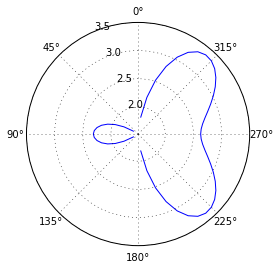

In [15]:
sweep_angle(trunc_y0[trunc_delay:], trunc_y1[:-trunc_delay], 0.3333, fc, phase_offset, step_size=1/80)

In [18]:
def sweep_angle_2(y0, y1, offset, step_size=1/80):
    phase_sweep = np.arange(-0.5,0.5+step_size,step_size) * 2 * pi
    all_summed = []
    for phase in phase_sweep:
        summed = y0 + np.exp(1j*(phase - offset)) * y1 #changed negative and made minus
        all_summed.append(np.abs(np.dot(summed, np.conj(summed))))
    
    ind = np.argmax(np.array(all_summed))
    
    x = []
    y = []
    for phase, energy in zip(phase_sweep, all_summed):
        x.append(energy*np.cos(phase/2 - pi/2))
        y.append(energy*np.sin(phase/2 - pi/2))
        
        #x.append(-energy*np.cos(phase/2 + pi/2))
        #y.append(-energy*np.sin(phase/2 + pi/2))
    
#     phase_sweep = phase_sweep - pi/2
    plt.polar(np.concatenate((phase_sweep/2, phase_sweep/2 - pi)), all_summed*2)
    #plt.polar(, all_summed)
    ax = plt.gca()
    ax.set_theta_zero_location('N')
    #ax.set_rscale('log')
    ax.set_rlim(np.max(np.log(all_summed))*1.25)

    
    print np.argmax(all_summed)
    print phase_sweep[ind] - offset

14
-1.4025953521


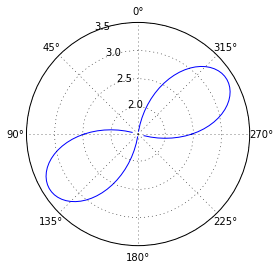

In [19]:
sweep_angle_2(trunc_y0[trunc_delay:], trunc_y1[:-trunc_delay], phase_offset)